# [CS 4476 Project 2: Local Feature Matching](https://dellaert.github.io/19F-4476/proj2.html)

This iPython notebook:  
(1) Loads and resizes images  
(2) Finds interest points in those images                 (you code this)  
(3) Describes each interest point with a local feature    (you code this)  
(4) Finds matching features                               (you code this)  
(5) Visualizes the matches  
(6) Evaluates the matches based on ground truth correspondences  

## Set up

In [1]:
%matplotlib inline
%matplotlib notebook
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np

from proj2_code.utils import load_image, PIL_resize, rgb2gray
from IPython.core.debugger import set_trace
import torch
import torchvision
import torchvision.transforms as transforms

# Notre Dame
image1 = load_image('../data/1a_notredame.jpg')
image2 = load_image('../data/1b_notredame.jpg')
eval_file = '../ground_truth/notredame.pkl'

# # Mount Rushmore -- this pair is relatively easy (still harder than Notre Dame, though)
# image1 = load_image('../data/2a_rushmore.jpg')
# image2 = load_image('../data/2b_rushmore.jpg')
# eval_file = '../ground_truth/rushmore.pkl'

# # Episcopal Gaudi -- This pair is relatively difficult
# image1 = load_image('../data/3a_gaudi.jpg')
# image2 = load_image('../data/3b_gaudi.jpg')
# eval_file = '../ground_truth/gaudi.pkl'

scale_factor = 0.5
image1 = PIL_resize(image1, (int(image1.shape[1]*scale_factor), int(image1.shape[0]*scale_factor)))
image2 = PIL_resize(image2, (int(image2.shape[1]*scale_factor), int(image2.shape[0]*scale_factor)))

image1_bw = rgb2gray(image1)
image2_bw = rgb2gray(image2)

#convert images to tensor
tensor_type = torch.FloatTensor
torch.set_default_tensor_type(tensor_type)
to_tensor = transforms.ToTensor()

image_input1 = to_tensor(image1_bw).unsqueeze(0)
image_input2 = to_tensor(image2_bw).unsqueeze(0)


# Part 1: Harris Corner Detector 
## Find distinctive points in each image (Szeliski 4.1.1)

In [2]:
## Verify each layer in the code, this will check if your implementation is correct or not.

## Do not modify the constructor of any layer (i.e. to take some custom arguments
## as input)

from unit_tests.harris_unit_test import (
    test_ImageGradientsLayer,
    test_ChannelProductLayer, 
    test_SecondMomentMatrixLayer, 
    test_CornerResponseLayer, 
    test_NMSLayer,
    verify
)

print('ImageGradientsLayer:', verify(test_ImageGradientsLayer))
print('ChannelProductLayer:', verify(test_ChannelProductLayer))
print('SecondMomentMatrixLayer:', verify(test_SecondMomentMatrixLayer))
print('CornerResponseLayer:', verify(test_CornerResponseLayer) )
print('NMSLayer:', verify(test_NMSLayer))


ImageGradientsLayer: "Correct"
ChannelProductLayer: "Correct"
SecondMomentMatrixLayer: "Correct"
tensor([[[[ -2.8000,   4.7500,  -9.0000],
          [-16.2000, -13.8000,  -1.2000],
          [  5.5500,   3.2000,   0.5500]]]])
tensor([[[[ -2.8000,   4.7500,  -9.0000],
          [-16.2000, -13.8000,  -1.2000],
          [  5.5500,   3.2000,   0.5500]]]])
CornerResponseLayer: "Correct"
NMSLayer: "Correct"


In [3]:
from proj2_code.HarrisNet import get_interest_points

Here we will call get_interest_points function in HarrisNet.py to detect 'interesting' points in the images. 

**IMPORTANT**
Make sure to add your code in get_interest_points function to call Harris Corner Detector.

3113 corners in image 1, 2706 corners in image 2


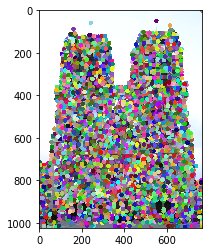

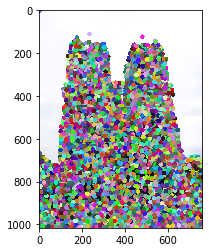

In [4]:
from utils import show_interest_points

x1, y1, _ = get_interest_points(image_input1)
x2, y2, _ = get_interest_points(image_input2)

x1, x2 = x1.detach().numpy(), x2.detach().numpy()
y1, y2 = y1.detach().numpy(), y2.detach().numpy()

# Visualize the interest points
c1 = show_interest_points(image1, x1, y1)
c2 = show_interest_points(image2, x2, y2)
plt.figure(); plt.imshow(c1)
plt.figure(); plt.imshow(c2)
print('{:d} corners in image 1, {:d} corners in image 2'.format(len(x1), len(x2)))

# Part 2: Sift Feature Descriptor
## Create feature vectors at each interest point (Szeliski 4.1.2)

In [5]:
from proj2_code.SIFTNet import (
    angles_to_vectors_2d_pytorch,
    HistogramLayer,
    SubGridAccumulationLayer,
    SIFTOrientationLayer,
    get_sift_subgrid_coords,
    get_siftnet_features
)
from proj2_code.torch_layer_utils import ImageGradientsLayer
from unit_tests.sift_unit_test import (
    test_angles_to_vectors_2d_pytorch,
    test_HistogramLayer,
    test_ImageGradientsLayer,
    test_SubGridAccumulationLayer,
    test_SIFTOrientationLayer,
    test_get_sift_subgrid_coords,
    test_SIFTNet,
    test_get_siftnet_features
)

print('angles_to_vectors_2d_pytorch:', verify(test_angles_to_vectors_2d_pytorch))
print('HistogramLayer:', verify(test_HistogramLayer))
print('ImageGradientsLayer:', verify(test_ImageGradientsLayer))
print('SIFTOrientationLayer:', verify(test_SIFTOrientationLayer) )
print('SIFTNet:', verify(test_SIFTNet) )
print('SubGridAccumulationLayer:', verify(test_SubGridAccumulationLayer))
print('get_sift_subgrid_coords:', verify(test_get_sift_subgrid_coords) )
print('get_siftnet_features:', verify(test_get_siftnet_features))

angles_to_vectors_2d_pytorch: "Correct"
HistogramLayer: "Correct"
ImageGradientsLayer: "Correct"
tensor([[  0.1962,  19.6157,   0.2494,  24.9441],
        [  0.1111,  16.6294,   0.0585,  29.4236],
        [ -0.0391,   3.9018,  -0.1666,  16.6671],
        [ -0.1663, -11.1114,  -0.2942,  -5.8527],
        [ -0.1962, -19.6157,  -0.2494, -24.9441],
        [ -0.1111, -16.6294,  -0.0585, -29.4236],
        [  0.0391,  -3.9018,   0.1666, -16.6671],
        [  0.1663,  11.1114,   0.2942,   5.8527],
        [  0.1962,  16.6294,   0.2942,  16.6671],
        [  0.0390,  11.1114,  -0.0585,  24.9441]], grad_fn=<SqueezeBackward0>)
SIFTOrientationLayer: "Correct"
SIFTNet: "Correct"
SubGridAccumulationLayer: "Correct"
get_sift_subgrid_coords: "Correct"
[[0.05107962 0.17272061 0.27522191 0.27983566 0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.13034542 0.12444288
  0.12444288 0.09605616 0.21337894 0.23221863 0.23221863 0.17924

In [6]:
image1_features = get_siftnet_features(image_input1, x1, y1)
image2_features = get_siftnet_features(image_input2, x2, y2)

ValueError: cannot reshape array of size 96 into shape (128,)

## Match features (Szeliski 4.1.3)

In [ ]:
#test your feature matching implementation
from unit_tests.feature_match_test import test_feature_matching, test_compute_dists
print('compute_dists:', verify(test_compute_dists))
print('feature_matching:', verify(test_feature_matching))

In [ ]:
from student_feature_matching import match_features
matches, confidences = match_features(image1_features, image2_features, x1, y1, x2, y2)
print('{:d} matches from {:d} corners'.format(len(matches), len(x1)))

## Visualization

You might want to set 'num_pts_to_visualize' and 'num_pts_to_evaluate' to some constant (e.g. 100) once you start detecting hundreds of interest points, otherwise things might get too cluttered. You could also threshold based on confidence.  
  
There are two visualization functions below. You can comment out one of both of them if you prefer.

In [ ]:
from proj2_code.utils import show_correspondence_circles, show_correspondence_lines
# num_pts_to_visualize = len(matches)
num_pts_to_visualize = 100
c1 = show_correspondence_circles(image1, image2,
                    x1[matches[:num_pts_to_visualize, 0]], y1[matches[:num_pts_to_visualize, 0]],
                    x2[matches[:num_pts_to_visualize, 1]], y2[matches[:num_pts_to_visualize, 1]])
plt.figure(); plt.imshow(c1)
plt.savefig('../results/vis_circles.jpg', dpi=1000)
c2 = show_correspondence_lines(image1, image2,
                    x1[matches[:num_pts_to_visualize, 0]], y1[matches[:num_pts_to_visualize, 0]],
                    x2[matches[:num_pts_to_visualize, 1]], y2[matches[:num_pts_to_visualize, 1]])
plt.figure(); plt.imshow(c2)
plt.savefig('../results/vis_lines.jpg', dpi=1000)

Comment out the function below if you are not testing on the Notre Dame, Episcopal Gaudi, and Mount Rushmore image pairs--this evaluation function will only work for those which have ground truth available.  
  
You can use `annotate_correspondences/collect_ground_truth_corr.py` to build the ground truth for other image pairs if you want, but it's very tedious. It would be a great service to the class for future years, though!

In [ ]:
from proj2_code.utils import evaluate_correspondence
# num_pts_to_evaluate = len(matches)
num_pts_to_evaluate = 100
_, c = evaluate_correspondence(image1, image2, eval_file, scale_factor,
                        x1[matches[:num_pts_to_evaluate, 0]], y1[matches[:num_pts_to_evaluate, 0]],
                        x2[matches[:num_pts_to_evaluate, 1]], y2[matches[:num_pts_to_evaluate, 1]])
plt.figure(); plt.imshow(c)
plt.savefig('../results/eval.jpg', dpi=1000)